# Анализ пользователей мобильного приложения

В проекте представлена информация о пользователях мобильного приложения стартапа за период в 2 недели в разбивке по операциям, устройствам и датам, а также проведен A/A/B-эксперимент по замене шрифтов в мобильном приложении по 3м группам, данные о котором сохранены в логах.  <br>
<br>
<b>Задачи проекта:</b> <br>
- проанализировать воронку продаж в приложении и изучить потери на каждом этапе перехода по воронке <br>
- оценить результаты A/A/B-эксперимента по новой инициативе для 3х групп (2 контрольные и 1 тестовая)<br>

<b>Содержание проекта:</b><br>
1. Предобработка<br>
2. Анализ данных<br>
3. Анализ воронки<br>
4. Анализ результатов A/A/B-эксперимента<br>
5. Общий вывод<br>

### Предобработка

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime as dt
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from plotly.subplots import make_subplots

<b>Описание датасета:</b> <br>
- название события<br>
- уникальный идентификатор пользователя<br>
- время события<br>
- номер группы эксперимента

In [2]:
# получение файла
data = pd.read_csv('data.csv',sep='\t')
display(data.head(1))
# отображение типов данных
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [3]:
# замена названий столбцов 
data.columns = ['event_name','device_id','timestamp','exp_id']

In [4]:
# перевод формата даты из timestamp в datetime
data['timestamp'] = data['timestamp'].map(lambda x: dt.utcfromtimestamp(x))
# добавление отдельного столбца даты
data['date'] = data['timestamp'].dt.date

In [5]:
# проверка файла логов на пропуски
print(data.isna().sum())
# проверка файла логов на дубликаты
print('Кол-во дубликатов:',data.duplicated().sum())

event_name    0
device_id     0
timestamp     0
exp_id        0
date          0
dtype: int64
Кол-во дубликатов: 413


In [6]:
# удаление строк-дубликатов из базы
data = data.drop_duplicates()

Были удалены строки-дубликаты (действие совершено в то же время до секунды)<br>
Даты были приведены к нужному формату

### Анализ данных

<b>/ Анализ событий </b>

In [7]:
# изучение событий, представленных в логах
print('Наименования событий в логе:',data['event_name'].unique())
print('Кол-во уникальныx device_id:',data['device_id'].nunique())

Наименования событий в логе: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
Кол-во уникальныx device_id: 7551


<b> Выводы: </b> <br>
В логе представлены 5 событий:<br>
-"Просмотр главной страницы" (MainScreenAppear)<br>
-"Просмотр страницы товара" (OffersScreenAppear)<br>
-"Добавление в корзину" (CartScreenAppear)<br>
-"Успешная оплата" (PaymentScreenSuccessful)<br>
-"Обучающая страница" (Tutorial)<br>
Всего в логе имеются данные по 7551 уникальным ID устройств

<b>/ Анализ событий по пользователям </b>

In [8]:
# среднее кол-во событий на пользователя (сумма всех событий)
events_by_user_count = data.groupby('device_id').agg({'event_name': 'count'})
events_by_user_count.columns = ['events_sum']
print('ТОП пользователей по кол-ву событий:')
display(events_by_user_count.sort_values(by='events_sum',ascending=False).head(5))

ТОП пользователей по кол-ву событий:


,events_sum
device_id,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221


<b> Выводы: </b> <br>
В ТОПе событий пользователи с более 1200 событий => в базе присутствуют аномальные данные по пользователям

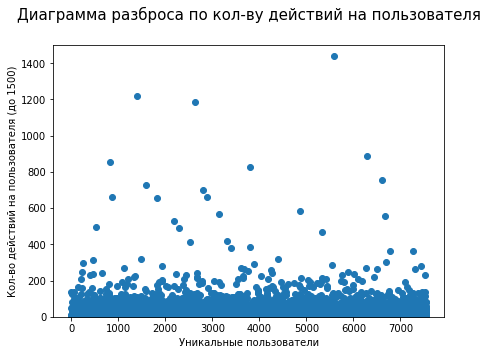

Оценка данных кол-ва действий на пользователя:


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events_sum, dtype: float64

95-й и 99-й перцентили количества действий на пользователя: [ 89.  200.5]


In [9]:
# построение графика разброса значений кол-ва действий на пользователя
x_values = pd.Series(range(0,len(events_by_user_count)))
plt.figure(figsize=(7,5))
plt.scatter(x_values, events_by_user_count['events_sum'])
plt.ylim([0, 1500])
plt.title('Диаграмма разброса по кол-ву действий на пользователя',size = 15, y=1.07)
plt.xlabel('Уникальные пользователи',size = 10)
plt.ylabel('Кол-во действий на пользователя (до 1500)',size = 10)
plt.show()
# оценка данных по сумме событий на пользователя
print('Оценка данных кол-ва действий на пользователя:')
display(events_by_user_count['events_sum'].describe())
# персентиль количества заказов на пользователя 
print('95-й и 99-й перцентили количества действий на пользователя:', np.percentile(events_by_user_count['events_sum'],[95,99]))

<b> Выводы: </b> <br>
-среднее кол-во действий на пользователя составляет 32,3 (медиана 20)<br>
-не более 5% пользователей совершили более 89 действий<br>
-не более 1% пользователей совершили более 200 действий<br>
<br>
Граница для для определения аномальных пользователей: > 200 (совершили в приложении больше 200 дейтсвий) => отсеиваем 1% 

In [10]:
# фильтрация базы - уданение пользователей, совершивших больше 200 дейтсвий
abnormal_users = events_by_user_count[events_by_user_count['events_sum'] > 200].index
print('Кол-во пользователей с кол-вом действий больше 200 (будут удалены):', len(abnormal_users))
print('Кол-во пользователей с кол-вом действий больше 200 (будут удалены):', round(len(abnormal_users)/ data['device_id'].nunique(),3))

Кол-во пользователей с кол-вом действий больше 200 (будут удалены): 76
Кол-во пользователей с кол-вом действий больше 200 (будут удалены): 0.01


<b>/ Анализ событий по датам </b>

Минимальная дата анализа: 2019-07-25
Максимальная дата анализа: 2019-08-07


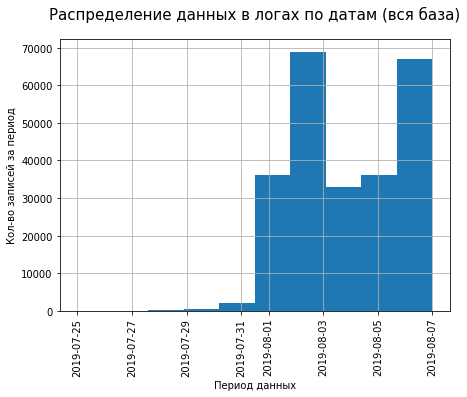

In [11]:
# анализ временного периода данных в логах (вся база логов)
print('Минимальная дата анализа:', data['date'].min())
print('Максимальная дата анализа:', data['date'].max())
plt.figure(figsize=(7,5))
data['date'].hist(bins = 10)
plt.title('Распределение данных в логах по датам (вся база)', size = 15, y=1.05 )
plt.xlabel('Период данных',size = 10)
plt.ylabel('Кол-во записей за период',size = 10)
plt.xticks(rotation=90)
plt.show()

<b> Выводы: </b> <br>
В логах представлены данные за период с 2019-07-25 по 2019-08-08 <br>
По гистограмме видно, что данных за период до 2019-08-01 крайне мало <br>
Также мало данных за последний день логов, 2019-08-08, однако эти данные необходимо оставить, так как в них могут быть события пользователей за период исследования

In [12]:
# нахождение кол-ва пользователей для удаления по причине диапазона дат (c 2019-08-01)
first_analysis_date = dt(2019,8,1).date()
data_filtered_by_date = data[data['date'] >= first_analysis_date]
print('Кол-во уникальных пользователей, которые будут удалены по причине диапазона дат:', data['device_id'].nunique() - data_filtered_by_date['device_id'].nunique()) 

Кол-во уникальных пользователей, которые будут удалены по причине диапазона дат: 17


In [13]:
# итоговая фильтрация базы логов для дальнейшего анализа
data_filtered = data[np.logical_not(data['device_id'].isin(abnormal_users))]
data_filtered = data_filtered[data_filtered['date'] >= first_analysis_date]
print('Кол-во уникальных пользователей, которые удалены по 2-м фильтрам:', data['device_id'].nunique() - data_filtered['device_id'].nunique())
print('Доля уникальных пользователей, которые удалены по 2-м фильрам, от общей базы:', round((data['device_id'].nunique() - data_filtered['device_id'].nunique())/data['device_id'].nunique(),5))

Кол-во уникальных пользователей, которые удалены по 2-м фильтрам: 93
Доля уникальных пользователей, которые удалены по 2-м фильрам, от общей базы: 0.01232


<b> Выводы: </b> <br>
Из изначального файла логов были удалены 93 уникальных пользователя, что составило 1,2% от всех уникальных пользователей в логах:<br>
-76 пользователей были удалены как "выбросы" (совершили более 200 действий)<br>
-17 пользователей были удалены, так как их действия были до периода анализа <br>


### Анализ воронки

In [14]:
# распределение по событиям (суммарное кол-во)
events_pivot = data_filtered.groupby('event_name').agg({'device_id': 'count'})
events_pivot.columns = ['events_count']
events_pivot['event_share_to_all_events_%'] = round(events_pivot['events_count'] / events_pivot['events_count'].sum(),3)
print('Распределение по событиям по кол-ву событий:')
display(events_pivot.sort_values(by = 'events_count', ascending = False))

Распределение по событиям по кол-ву событий:


,events_count,event_share_to_all_events_%
event_name,,
MainScreenAppear,113264,0.548
OffersScreenAppear,40956,0.198
CartScreenAppear,29250,0.142
PaymentScreenSuccessful,22164,0.107
Tutorial,981,0.005


<b> Выводы: </b> <br>
Порядок событий для расчета доли перехода по воронке: <br>
"Просмотр главной страницы" => "Просмотр страницы товара" => "Добавление в корзину" => "Успешная оплата<br>
<br>
Событие "Обучающая страница" можно не учитывать в воронке, так может быть просмотрено на любом шаге пользователя 

In [15]:
# создание таблицы для расчета доли переходов по воронке 
users_events_success = data_filtered.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by = 'device_id', ascending = False)
users_events_success.columns = ['users_unique']
users_events_success = users_events_success.drop(['Tutorial'])
users_events_success['share_to_previous_event_%'] = round(users_events_success['users_unique'] / users_events_success['users_unique'].shift(1),3)
display(users_events_success)
# расчет доли перехода от "Просмотр главной страницы" к "Успешная оплата"
print('Доля перехода от Просмотр главной страницы к Успешная оплата, %:', round(data_filtered[data_filtered['event_name'] == 'PaymentScreenSuccessful']['device_id'].nunique() / data_filtered[data_filtered['event_name'] == 'MainScreenAppear']['device_id'].nunique() ,3))

,users_unique,share_to_previous_event_%
event_name,,
MainScreenAppear,7344,NaN
OffersScreenAppear,4517,0.615
CartScreenAppear,3658,0.810
PaymentScreenSuccessful,3463,0.947


Доля перехода от Просмотр главной страницы к Успешная оплата, %: 0.472


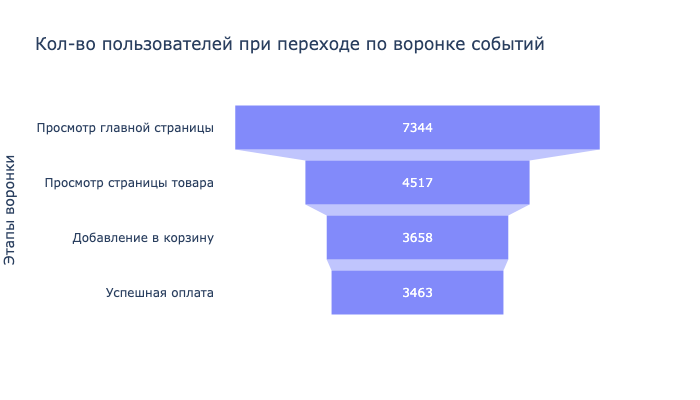

In [16]:
# визуализация
fig = go.Figure(go.Funnel(
    y = ["Просмотр главной страницы", "Просмотр страницы товара", "Добавление в корзину", "Успешная оплата"],
    x = [users_events_success.loc['MainScreenAppear','users_unique'], users_events_success.loc['OffersScreenAppear','users_unique'], users_events_success.loc['CartScreenAppear','users_unique'], users_events_success.loc['PaymentScreenSuccessful','users_unique']],
    opacity = 0.8)) 
fig.update_layout(
    title="Кол-во пользователей при переходе по воронке событий",
    yaxis_title="Этапы воронки",
    plot_bgcolor = "rgba(0,0,0,0)",
    # width=700, height=400
    )
fig.show(renderer='png', width = 700, height = 400)

<b> Выводы: </b> <br>
Переходы пользователей по воронке:<br>
-с Главной страницы на Старницу товара перешли 62% пользователей (потери = 38%)<br>
-со Страницы товара к Добавлению в корзину перешли 81% пользователей (потери = 19%)<br>
-из Корзины к Успешной оплате перешли 95% пользователей (потери = 5%)<br>
<br>
=> больше всего пользователей теряется на переходе с Главной страницы на Страницу товара (38%)<br>
=> от первого события (Просмотр главной страницы) до Успешной оплаты доходит 47% пользователей (потери = 53%)<br>

### Анализ результатов A/A/B-эксперимента

Описание групп A/A/B-эксперимента: 246 и 247 — контрольные группы, 248 — экспериментальна


In [17]:
# распределение данных в логах по группам анализа А/А/В
users_by_groups = data_filtered.pivot_table(index='exp_id', values = 'device_id', aggfunc = 'nunique')
users_by_groups['share_%'] = users_by_groups['device_id'] / users_by_groups['device_id'].sum()
print('Распределение пользователей по группам теста А/А/В:')
display(users_by_groups)
print('Колличество уникальных пользователей:', users_by_groups['device_id'].sum())
print('Колличество уникальных пользователей в сумме (всего):', data_filtered['device_id'].nunique())
print('Колличество уникальных пользователей, попавших в несколько групп:', users_by_groups['device_id'].sum() - data_filtered['device_id'].nunique())

Распределение пользователей по группам теста А/А/В:


,device_id,share_%
exp_id,,
246,2456,0.329311
247,2491,0.334004
248,2511,0.336685


Колличество уникальных пользователей: 7458
Колличество уникальных пользователей в сумме (всего): 7458
Колличество уникальных пользователей, попавших в несколько групп: 0


<b> Выводы: </b> <br>
Пользователи распределены равномерно по группам А/А/В (~33%) => разбивка эксперимента на группы работает корректно<br>

In [18]:
# распределение по событиям и уникальным пользователям в группах 
data_analysis = data_filtered.pivot_table(index='event_name',columns='exp_id',values='device_id',aggfunc='nunique')
data_analysis.columns = ['group_A1','group_A2', 'group_B']
# сброс индексов и удаление события "Обучающая страница" (не учитывается в воронке)
data_analysis = data_analysis.sort_values(by='group_B',ascending = False)
data_analysis = data_analysis.drop(['Tutorial'])
# рассчитаем долю к предыдущему событию методом shift
data_analysis['group_A1_share_to_prev_event'] = round(data_analysis['group_A1'] / data_analysis['group_A1'].shift(1),3)
data_analysis['group_A2_share_to_prev_event'] = round(data_analysis['group_A2'] / data_analysis['group_A2'].shift(1),3)
data_analysis['group_B_share_to_prev_event'] = round(data_analysis['group_B'] / data_analysis['group_B'].shift(1),3)
display(data_analysis)

,group_A1,group_A2,group_B,group_A1_share_to_prev_event,group_A2_share_to_prev_event,group_B_share_to_prev_event
event_name,,,,,,
MainScreenAppear,2423,2454,2467,NaN,NaN,NaN
OffersScreenAppear,1514,1498,1505,0.625,0.610,0.610
CartScreenAppear,1238,1216,1204,0.818,0.812,0.800
PaymentScreenSuccessful,1172,1136,1155,0.947,0.934,0.959


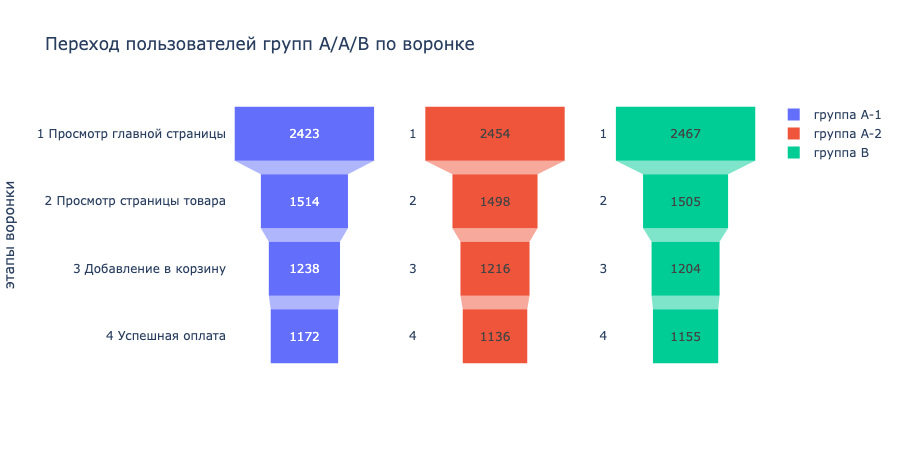

In [19]:
#визуализация
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "Funnel"}, {"type": "Funnel"}, {"type": "Funnel"}]])
fig.add_trace(go.Funnel(
    x= [data_analysis.loc['MainScreenAppear','group_A1'], data_analysis.loc['OffersScreenAppear','group_A1'], data_analysis.loc['CartScreenAppear','group_A1'], data_analysis.loc['PaymentScreenSuccessful','group_A1']], 
    y =["1 Просмотр главной страницы", "2 Просмотр страницы товара", "3 Добавление в корзину", "4 Успешная оплата"],
    name='группа А-1' ),
    1, 1)
fig.add_trace(go.Funnel(
    x= [data_analysis.loc['MainScreenAppear','group_A2'], data_analysis.loc['OffersScreenAppear','group_A2'], data_analysis.loc['CartScreenAppear','group_A2'], data_analysis.loc['PaymentScreenSuccessful','group_A2']], 
    y =["1", "2", "3", "4"],
    name='группа А-2'), 
    1, 2)
fig.add_trace(go.Funnel(
    x= [data_analysis.loc['MainScreenAppear','group_B'], data_analysis.loc['OffersScreenAppear','group_B'], data_analysis.loc['CartScreenAppear','group_B'], data_analysis.loc['PaymentScreenSuccessful','group_B']], 
    y =["1", "2", "3", "4"],
    name='группа В'), 
    1, 3)
fig.update_layout(
    title_text='Переход пользователей групп А/А/В по воронке',
    yaxis_title="этапы воронки", 
    plot_bgcolor = "rgba(0,0,0,0)",
    #width=900, height=450
    )
fig.show(renderer='png', width = 900, height = 450)

<b> Выводы: </b> <br>
Доли переходов по шагам воронки среди пользователей групп А/А/В примерно одинаковы => необходима оценка статистически значимого различия долей<br>

<b> / Ввод функций для проверки статистически значимого различия долей </b>

In [20]:
# функция расчета p-value для нахождения статистически значимого различия долей
def stats (group_1_trials, group_1_successes, group_2_trials, group_2_successes):
    p1 = group_1_successes/group_1_trials
    p2 = group_2_successes/group_2_trials
    p_combined = (group_1_successes + group_2_successes) / (group_1_trials + group_2_trials)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_1_trials + 1/group_2_trials))
    distr = st.norm(0, 1)  
    p_value = ((1 - distr.cdf(abs(z_value))) * 2)
    return p_value

In [21]:
# функция сравнения значения p-value с уровнем значимости alpha = 5%
def pvalue_05 (test):
    alpha = 0.05
    if test < alpha: print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else: print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    return 

In [22]:
# функция сравнения значения p-value уровнем значимости alpha = 1%
def pvalue_01 (test):
    alpha = 0.01
    if test < alpha: print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else: print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    return 

<b> / Ввод числовых значений пользователей в группах для расчетов </b>

In [23]:
# создание переменных для удобства работы с функцией
# контрольные группы А1/А2 (246, 247)
g246_nunique = data_filtered[data_filtered['exp_id'] == 246]['device_id'].nunique()
g246_Main = data_filtered[(data_filtered['exp_id'] == 246)&(data_filtered['event_name'] == 'MainScreenAppear')]['device_id'].nunique()
g246_Offers = data_filtered[(data_filtered['exp_id'] == 246)&(data_filtered['event_name'] == 'OffersScreenAppear')]['device_id'].nunique()
g246_Cart = data_filtered[(data_filtered['exp_id'] == 246)&(data_filtered['event_name'] == 'CartScreenAppear')]['device_id'].nunique()
g246_Payment = data_filtered[(data_filtered['exp_id'] == 246)&(data_filtered['event_name'] == 'PaymentScreenSuccessful')]['device_id'].nunique()
g247_nunique = data_filtered[data_filtered['exp_id'] == 247]['device_id'].nunique()
g247_Main = data_filtered[(data_filtered['exp_id'] == 247)&(data_filtered['event_name'] == 'MainScreenAppear')]['device_id'].nunique()
g247_Offers = data_filtered[(data_filtered['exp_id'] == 247)&(data_filtered['event_name'] == 'OffersScreenAppear')]['device_id'].nunique()
g247_Cart = data_filtered[(data_filtered['exp_id'] == 247)&(data_filtered['event_name'] == 'CartScreenAppear')]['device_id'].nunique() 
g247_Payment = data_filtered[(data_filtered['exp_id'] == 247)&(data_filtered['event_name'] == 'PaymentScreenSuccessful')]['device_id'].nunique()
# объединенные значения для групп А1+А2 (246 + 247)
g246_g247_nunique = g246_nunique + g247_nunique
g246_g247_Main = g246_Main + g247_Main
g246_g247_Offers = g246_Offers + g247_Offers
g246_g247_Cart = g246_Cart + g247_Cart
g246_g247_Payment = g246_Payment + g247_Payment
# экспериментальная группа В (248)
g248_nunique = data_filtered[data_filtered['exp_id'] == 248]['device_id'].nunique()
g248_Main = data_filtered[(data_filtered['exp_id'] == 248)&(data_filtered['event_name'] == 'MainScreenAppear')]['device_id'].nunique() 
g248_Offers = data_filtered[(data_filtered['exp_id'] == 248)&(data_filtered['event_name'] == 'OffersScreenAppear')]['device_id'].nunique() 
g248_Cart = data_filtered[(data_filtered['exp_id'] == 248)&(data_filtered['event_name'] == 'CartScreenAppear')]['device_id'].nunique() 
g248_Payment = data_filtered[(data_filtered['exp_id'] == 248)&(data_filtered['event_name'] == 'PaymentScreenSuccessful')]['device_id'].nunique() 

<b>/ Проверка статистически значимой разницы долей у групп </b>

<b>Формирование гипотез для проверки: </b> <br>
Нулевая гипотеза: различий в конверсии (доли переходов) по этапам воронки между группами А/А/В нет <br>
Альтернативная: между группами разная конверсия (доля переходов) по этапам воронки <br>
<br>
Уровень значимости для рачета различий (alpha): 5% и 1% (доля ошибки в 5% и в 1%) <br>
<br>
Результат нахождения p-значения:<br>
- p-value > значения alpha => нулевая гипотеза верна, нет оснований считать доли (конверсии) разными <br>
- p-value < значения alpha => нулевую гипотезу отвергаем, между долями (конверсиями) групп есть статистически значимая разница 

<b>/ Проверка статистически значимой разницы долей у групп А1/А2 (246 и 247) с уровнем alpha = 5%</b>

In [24]:
# проверка статистически значимого различия долей "Просмотр главной страницы" ко всем пользователям
print('Просмотр главной страницы ко всем пользователям группы: различие долей групп А1/А2')
test_MainScreen_AA = stats(g246_nunique,g246_Main,g247_nunique,g247_Main)
print('p-значение: ', round(test_MainScreen_AA,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_MainScreen_AA))
print()
# проверка статистически значимого различия события "Просмотр страницы товара" к "Просмотр главной страницы"
print('Просмотр страницы товара к просмотру главной страницы: различие долей групп А1/А2')
test_OffersScreen_AA = stats(g246_Main,g246_Offers,g247_Main,g247_Offers)
print('p-значение: ', round(test_OffersScreen_AA,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_OffersScreen_AA))
print()
# проверка статистически значимого различия события "Добавление в корзину" к "Просмотр страницы товара"
print('Добавление в корзину к просмотру страницы товара: различие долей групп А1/А2')
test_CartScreen_AA = stats(g246_Offers,g246_Cart,g247_Offers,g247_Cart)
print('p-значение: ', round(test_CartScreen_AA,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_CartScreen_AA))
print()
# проверка статистически значимого различия события "Успешная оплата" к "Добавление в корзину"
print('Успешная оплата к добавлению в корзину: различие долей групп А1/А2')
test_PaymentScreen_AA = stats(g246_Cart,g246_Payment,g247_Cart,g247_Payment)
print('p-значение: ', round(test_PaymentScreen_AA,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_PaymentScreen_AA))

Просмотр главной страницы ко всем пользователям группы: различие долей групп А1/А2
p-значение:  0.6731
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Просмотр страницы товара к просмотру главной страницы: различие долей групп А1/А2
p-значение:  0.3004
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Добавление в корзину к просмотру страницы товара: различие долей групп А1/А2
p-значение:  0.67418
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Успешная оплата к добавлению в корзину: различие долей групп А1/А2
p-значение:  0.19139
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


<b> Выводы: </b> <br>
При сравнении различия долей контрольных групп А/А - статистически значимые различия не обнаружены<br>
=> контрольные группы формируются корректно (настройки эксперимента верны)<br>
=> можно проводить сравнение групп А/А с экпериментальной группой В<br>

<b>/ Проверка статистически значимой разницы долей у групп А1 / B (246 и 248) с уровнем alpha = 5%</b>

In [25]:
# проверка статистически значимого различия долей "Просмотр главной страницы" ко всем пользователям
print('Просмотр главной страницы ко всем пользователям группы: различие долей групп А1/В')
test_MainScreen_A1B = stats(g246_nunique,g246_Main,g248_nunique,g248_Main)
print('p-значение: ', round(test_MainScreen_A1B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_MainScreen_A1B))
print()
# проверка статистически значимого различия события "Просмотр страницы товара" к "Просмотр главной страницы"
print('Просмотр страницы товара к просмотру главной страницы: различие долей групп А1/В')
test_OffersScreen_A1B = stats(g246_Main,g246_Offers,g248_Main,g248_Offers)
print('p-значение: ', round(test_OffersScreen_A1B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_OffersScreen_A1B))
print()
# проверка статистически значимого различия события "Добавление в корзину" к "Просмотр страницы товара"
print('Добавление в корзину к просмотру страницы товара: различие долей групп А1/В')
test_CartScreen_A1B = stats(g246_Offers,g246_Cart,g248_Offers,g248_Cart)
print('p-значение: ', round(test_CartScreen_A1B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_CartScreen_A1B))
print()
# проверка статистически значимого различия события "Успешная оплата" к "Добавление в корзину"
print('Успешная оплата к добавлению в корзину: различие долей групп А1/В')
test_PaymentScreen_A1B = stats(g246_Cart,g246_Payment,g248_Cart,g248_Payment)
print('p-значение: ', round(test_PaymentScreen_A1B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_PaymentScreen_A1B))

Просмотр главной страницы ко всем пользователям группы: различие долей групп А1/В
p-значение:  0.2438
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Просмотр страницы товара к просмотру главной страницы: различие долей групп А1/В
p-значение:  0.28728
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Добавление в корзину к просмотру страницы товара: различие долей групп А1/В
p-значение:  0.21615
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Успешная оплата к добавлению в корзину: различие долей групп А1/В
p-значение:  0.14125
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


<b>/ Проверка статистически значимой разницы долей у групп А_2 / B (247 и 248) с уровнем alpha = 5%</b>

In [26]:
# проверка статистически значимого различия долей "Просмотр главной страницы" ко всем пользователям
print('Просмотр главной страницы ко всем пользователям группы: различие долей групп А2/В')
test_MainScreen_A2B = stats(g247_nunique,g247_Main,g248_nunique,g248_Main)
print('p-значение: ', round(test_MainScreen_A2B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_MainScreen_A2B))
print()
# проверка статистически значимого различия события "Просмотр страницы товара" к "Просмотр главной страницы"
print('Просмотр страницы товара к просмотру главной страницы: различие долей групп А2/В')
test_OffersScreen_A2B = stats(g247_Main,g247_Offers,g248_Main,g248_Offers)
print('p-значение: ', round(test_OffersScreen_A2B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_OffersScreen_A2B))
print()
# проверка статистически значимого различия события "Добавление в корзину" к "Просмотр страницы товара"
print('Добавление в корзину к просмотру страницы товара: различие долей групп А2/В')
test_CartScreen_A2B = stats(g247_Offers,g247_Cart,g248_Offers,g248_Cart)
print('p-значение: ', round(test_CartScreen_A2B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_CartScreen_A2B))
print()
# проверка статистически значимого различия события "Успешная оплата" к "Добавление в корзину"
print('Успешная оплата к добавлению в корзину: различие долей групп А2/В')
test_PaymentScreen_A2B = stats(g247_Cart,g247_Payment,g248_Cart,g248_Payment)
print('p-значение: ', round(test_PaymentScreen_A2B,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_PaymentScreen_A2B))

Просмотр главной страницы ко всем пользователям группы: различие долей групп А2/В
p-значение:  0.45453
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Просмотр страницы товара к просмотру главной страницы: различие долей групп А2/В
p-значение:  0.97824
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Добавление в корзину к просмотру страницы товара: различие долей групп А2/В
p-значение:  0.41571
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Успешная оплата к добавлению в корзину: различие долей групп А2/В
p-значение:  0.00601
Результат при alpha 5%:
Отвергаем нулевую гипотезу: между долями есть значимая разница
None


<b>/ Проверка статистически значимой разницы долей у объединенной группы групп А_1 + А_2 / B (246+247 и 248) с уровнем alpha = 5%</b>

In [27]:
# проверка статистически значимого различия долей "Просмотр главной страницы" ко всем пользователям
print('Просмотр главной страницы ко всем пользователям группы: различие долей групп А+А/В')
test_MainScreen_AAB = stats(g246_g247_nunique,g246_g247_Main,g248_nunique,g248_Main)
print('p-значение: ', round(test_MainScreen_AAB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_MainScreen_AAB))
print()
# проверка статистически значимого различия события "Просмотр страницы товара" к "Просмотр главной страницы"
print('Просмотр страницы товара к просмотру главной страницы: различие долей групп А+А/В')
test_OffersScreen_AAB = stats(g246_g247_Main,g246_g247_Offers,g248_Main,g248_Offers)
print('p-значение: ', round(test_OffersScreen_AAB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_OffersScreen_AAB))
print()
# проверка статистически значимого различия события "Добавление в корзину" к "Просмотр страницы товара"
print('Добавление в корзину к просмотру страницы товара: различие долей групп А+А/В')
test_CartScreen_AAB = stats(g246_g247_Offers,g246_g247_Cart,g248_Offers,g248_Cart)
print('p-значение: ', round(test_CartScreen_AAB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_CartScreen_AAB))
print()
# проверка статистически значимого различия события "Успешная оплата" к "Добавление в корзину"
print('Успешная оплата к добавлению в корзину: различие долей групп А+А/В')
test_PaymentScreen_AAB = stats(g246_g247_Cart,g246_g247_Payment,g248_Cart,g248_Payment)
print('p-значение: ', round(test_PaymentScreen_AAB,5))
print('Результат при alpha 5%:')
print(pvalue_05(test_PaymentScreen_AAB))

Просмотр главной страницы ко всем пользователям группы: различие долей групп А+А/В
p-значение:  0.26186
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Просмотр страницы товара к просмотру главной страницы: различие долей групп А+А/В
p-значение:  0.53052
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Добавление в корзину к просмотру страницы товара: различие долей групп А+А/В
p-значение:  0.23406
Результат при alpha 5%:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Успешная оплата к добавлению в корзину: различие долей групп А+А/В
p-значение:  0.01741
Результат при alpha 5%:
Отвергаем нулевую гипотезу: между долями есть значимая разница
None


<b> Выводы: </b> <br>
Результаты нахождения статистически значимой разницы долей между группами с уровнем значимости alpha = 5%:<br>
Было проведено 16 тестов (по 4 теста для 4х групп сравнений)<br>
<br>
Статистически значимое отличие между группами при alpha = 5%:<br>
-А1/А2: не найдено<br>
-А1/В: не найдено<br>
-А2/В: найдено для события Успешная оплата к добавлению в корзину<br>
-А1+А2/В: найдено для события Успешная оплата к добавлению в корзину<br>
<br>
=> после нахождения различий необходимо сравнить числовые значения долей для события Успешная оплата<br>

In [28]:
# найдем числовые различия в группах (у кого лучше показатели)
print('Доля перехода из Корзины к Успешной оплате :')
print('у объединенных групп А+А (246+247):', round(g246_g247_Payment/g246_g247_Cart,3))
print('у группы В (248) :', round(g248_Payment/g248_Cart,3))
print('Разница долей (группа В - объединенные группы А+А) :', round(g248_Payment/g248_Cart - g246_g247_Payment/g246_g247_Cart,3))

Доля перехода из Корзины к Успешной оплате :
у объединенных групп А+А (246+247): 0.941
у группы В (248) : 0.959
Разница долей (группа В - объединенные группы А+А) : 0.019


<b> Выводы: </b> <br>
При сравнении долей в группах А/А/В было выявлено, что доля перехода из Корзины у Успешной оплате у групп различная: <br>
-переход из Корзины к Успешной оплате у экспериментальной группы 248 лучше на 2 процентных пункта, чем у объединенной контрольной группы 246 и 247   <br>

<b>/ Дополнительный расчет статистической значимости различия долей с уровнем значимости alpha = 1%</b>

In [29]:
# Дополнительно: нахождение при уровне значимости alpha = 1%
print('Результат при alpha 1%:')
print()
print('Различие долей групп А/А:')
print('Просмотр главной страницы ко всем пользователям группы:')
print(pvalue_01(test_MainScreen_AA))
print('Просмотр страницы товара к просмотру главной страницы:')
print(pvalue_01(test_OffersScreen_AA))
print('Добавление в корзину к просмотру страницы товара:')
print(pvalue_01(test_CartScreen_AA))
print('Успешная оплата к добавлению в корзину:')
print(pvalue_01(test_PaymentScreen_AA))
print()
print('Различие долей групп А1/В:')
print('Просмотр главной страницы ко всем пользователям группы:')
print(pvalue_01(test_MainScreen_A1B))
print('Просмотр страницы товара к просмотру главной страницы:')
print(pvalue_01(test_OffersScreen_A1B))
print('Добавление в корзину к просмотру страницы товара:')
print(pvalue_01(test_CartScreen_A1B))
print('Успешная оплата к добавлению в корзину:')
print(pvalue_01(test_PaymentScreen_A1B))
print()
print('Различие долей групп А2/В:')
print('Просмотр главной страницы ко всем пользователям группы:')
print(pvalue_01(test_MainScreen_A2B))
print('Просмотр страницы товара к просмотру главной страницы:')
print(pvalue_01(test_OffersScreen_A2B))
print('Добавление в корзину к просмотру страницы товара:')
print(pvalue_01(test_CartScreen_A2B))
print('Успешная оплата к добавлению в корзину:')
print(pvalue_01(test_PaymentScreen_A2B))
print()
print('Различие долей групп А+А/В:')
print('Просмотр главной страницы ко всем пользователям группы:')
print(pvalue_01(test_MainScreen_AAB))
print('Просмотр страницы товара к просмотру главной страницы:')
print(pvalue_01(test_OffersScreen_AAB))
print('Добавление в корзину к просмотру страницы товара:')
print(pvalue_01(test_CartScreen_AAB))
print('Успешная оплата к добавлению в корзину:')
print(pvalue_01(test_PaymentScreen_AAB))

Результат при alpha 1%:

Различие долей групп А/А:
Просмотр главной страницы ко всем пользователям группы:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
Просмотр страницы товара к просмотру главной страницы:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
Добавление в корзину к просмотру страницы товара:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
Успешная оплата к добавлению в корзину:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None

Различие долей групп А1/В:
Просмотр главной страницы ко всем пользователям группы:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
Просмотр страницы товара к просмотру главной страницы:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
Добавление в корзину к просмотру страницы товара:
Не получилось отвергнуть нулевую гипотезу, нет оснований счит

<b> Выводы: </b> <br>
Результаты нахождения статистически значимой разницы долей между группами с уровнем значимости alpha = 1%:<br>
Было проведено 16 тестов (по 4 теста для 4х групп сравнений)<br>
<br>
Статистически значимое отличие между группами при alpha = 1%:<br>
-А1/А2: не найдено<br>
-А1/В: не найдено<br>
-А2/В: найдено для события Успешная оплата к добавлению в корзину<br>
-А1+А2/В: не найдено<br>
<br>
<b> Отличия сравнений с уровнем значимости alpha = 5% и alpha = 1%: </b> <br>
-с уровнем значимости alpha = 1% не найдено различия в долей перехода из Корзины у Успешной оплате между объединенными контрольными группами А+А (246+247) и экспериментальной группой В (248)<br>
-с уровнем значимости alpha = 1% найдено различие перехода из Корзины у Успешной оплате только при сравнении групп А2/В (контрольной 247 и экспериментальной 248)

<br>
<b>Вывод по результатам проверки А/А/В-эксперимента:</b> <br>
<br>
1. Проведен анализ различия долей с уровнем значимости alpha = 5%:<br>
- обнаружены статистически значимые различия долей перехода из Корзины у Успешной оплате для групп А2/В и для объединенных групп А1+А2/В <br>
- переход из Корзины к Успешной оплате у экспериментальной группы 248 лучше на 2 процентного пункта, чем у объединенной контрольной группы 246 и 247 <br>
=> можно сделать вывод, что экспериментальная группа лучше объединенный контрольных групп с вероятной долей ошибки 5% <br>
<br>
2. Проведен анализ различия долей с уровнем значимости alpha = 1%:<br>
- обнаружены статистически значимые различия долей перехода из Корзины у Успешной оплате для групп А2/В<br>
- в отличие от уровня значимости в 5% статистически значимых различий долей перехода из Корзины у Успешной оплате для объединенных групп А1+А2/В не обнаружено<br>
=> можно сделать вывод, что с вероятностью ошибки в 1% разницы в долях контрольных и экспериментальных групп нет <br>
<br>
<b>Общий вывод по результатам эксперимента:</b><br>
- не обнаружено статистически значимых различий в переходах по воронке для шагов "Просмотр главной страницы", "Просмотр страницы товара", "Добавление в корзину" между контрольными группами и экспериментальной группой<br>
- обнаружено статистически значимое различие в переходе по воронке из Корзины у Успешной оплате между объединенными контрольными группами и экспериментальной группой (с вероятной долей ошибки 5%)<br>
- не обнаружено статистически значимого различия в переходе по воронке из Корзины у Успешной оплате между объединенными контрольными группами и экспериментальной группой (с вероятной долей ошибки 1%)<br>
<br>
=> на основании данных выше можно сделать вывод, что разница между контрольными группами и экспериментальной группой крайне мала<br>
=> изменения, которые были протестированы в эксперименте, не будут значимыми для пользователей => с большой долей вероятности можно проводить данные изменения <br>

### Общий вывод

<b>В рамках проекта по анализу пользователей мобильного приложения и оценке А/А/В-экперимента была проведена следующая работа::</b> <br>
<br>
1. Проведена предобработка и анализ датасета:
- удалены дубликаты
- удалены выбросы (аномальные значения по пользователям) и нерелевантные даты <br>
<br>
2. Проведен анализ воронки событий<br>
- больше всего пользователей теряется на переходе с Главной страницы на Страницу товара (38%)<br>
- от первого события (Просмотр главной страницы) до Успешной оплаты доходит 48% пользователей (потери = 52%)<br>
<br>    
3. Проведен анализ А/А/В-экперимента:<br>    
- проанализированы различия долей для 2х контрольных групп и 1 экспериментальной группы с уровнем значимости alpha = 5% и 1%  <br>
- разница между контрольными группами и экспериментальной группой обнаружена только для события переход из Корзины к Успешной оплате <br>
- разница между контрольными группами и экспериментальной группой крайне мала (с долей ошибки 1% разницы нет)<br>
<br>
Общий вывод по результатам А/А/В-экперимента: изменения, которые были протестированы в экперименте, не будут значимыми для пользователей<br>